In [1]:
from update_asset_exposure import fetch_latest_asset_exposure, ensure_asset_exposure_is_current
import pandas as pd
from mainnet_launch.data_fetching.dex_screener.get_pool_usd_liqudity import get_token_pair_pools, get_dex_sided_liquidity

from mainnet_launch.data_fetching.coingecko.get_pools_by_token import fetch_token_prices_from_coingecko, fetch_n_hops_from_tokens_with_coingecko
from mainnet_launch.constants import ETH_CHAIN, BASE_CHAIN, SONIC_CHAIN


import asyncio
import aiohttp

# ensure_asset_exposure_is_current()


def _fetch_pairs_via_dex_screener():
    """
    Fetch pairs for a given token address using DexScreener.
    """
    df = fetch_latest_asset_exposure()
    mainnet_df = df[df['chain_id'] == 1]
    pair_df = asyncio.run(get_token_pair_pools('ethereum', mainnet_df['token_address'].unique().tolist()))
    large_pairs_df = pair_df[pair_df['liquidity_usd'] > 100_000].copy()
    large_pairs_df = pair_df.copy()

    tokens = list(set([*large_pairs_df['base_token_address'].unique().tolist(), *large_pairs_df['quote_token_address'].unique().tolist()]))

    prices_df = fetch_token_prices_from_coingecko(ETH_CHAIN, tokens)

    token_address_to_usd_prices = prices_df.set_index('token_address')['usd_price'].to_dict()
    large_pairs_df['usd_quote_liqudity'] = large_pairs_df['quote_token_address'].map(token_address_to_usd_prices) * large_pairs_df['liquidity_quote']
    large_pairs_df['usd_base_liqudity'] = large_pairs_df['base_token_address'].map(token_address_to_usd_prices) * large_pairs_df['liquidity_base']
    large_pairs_df['total_liquidity_usd'] = large_pairs_df['usd_quote_liqudity'] + large_pairs_df['usd_base_liqudity']
    return large_pairs_df

In [3]:
def fetch_large_pairs_df_from_coingecko():
    """
    Fetch pairs for a given token address using DexScreener.
    """
    df = fetch_latest_asset_exposure()
    mainnet_df = df[df['chain_id'] == 1]
    pair_df = asyncio.run(fetch_n_hops_from_tokens_with_coingecko(mainnet_df['token_address'].unique().tolist(), 'ethereum', min_USD_reserves=1, n_hops=1))
    large_pairs_df = pair_df[pair_df['liquidity_usd'] > 100_000].copy()
    large_pairs_df = pair_df.copy()

    tokens = list(set([*large_pairs_df['base_token_address'].unique().tolist(), *large_pairs_df['quote_token_address'].unique().tolist()]))

    prices_df = fetch_token_prices_from_coingecko(ETH_CHAIN, tokens)

    token_address_to_usd_prices = prices_df.set_index('token_address')['usd_price'].to_dict()
    large_pairs_df['usd_quote_liqudity'] = large_pairs_df['quote_token_address'].map(token_address_to_usd_prices) * large_pairs_df['liquidity_quote']
    large_pairs_df['usd_base_liqudity'] = large_pairs_df['base_token_address'].map(token_address_to_usd_prices) * large_pairs_df['liquidity_base']
    large_pairs_df['total_liquidity_usd'] = large_pairs_df['usd_quote_liqudity'] + large_pairs_df['usd_base_liqudity']
    return large_pairs_df

large_pairs_df = fetch_large_pairs_df_from_coingecko()

Checking 21 tokens in this hop. 0


HTTPError: 404 Client Error: Not Found for url: https://pro-api.coingecko.com/api/v3/onchain/networks/None/tokens/0xa0d3707c569ff8c87fa923d3823ec5d81c98be78/pools?sort=h24_volume_usd_liquidity_desc&include=base_token&include=quote_token

In [ ]:
# some options
# maybe coingecko is better at finding pairs?


In [ ]:
def build_our_token_to_total_other_token_liquidity(large_pairs_df):

    our_tokens = df['token_address'].tolist()

    our_token_to_total_other_token_liquidity = {}

    token_symol_to_dfs = {}

    for token in our_tokens:
        # also works by token address
        sub_df = large_pairs_df[(large_pairs_df['base_token_address'] == token) | (large_pairs_df['quote_token_address'] == token)]
        if sub_df.empty:
            continue

        quote_token_is_target = sub_df[(sub_df['quote_token_address'] == token)]

        quote_liqudity = quote_token_is_target.groupby('base_token_symbol')['usd_base_liqudity'].sum().to_dict()

        base_token_is_target = sub_df[(sub_df['base_token_address'] == token)]
        base_liqudity = base_token_is_target.groupby('quote_token_symbol')['usd_quote_liqudity'].sum().to_dict()

        for k, v in base_liqudity.items():
            if k not in quote_liqudity:
                quote_liqudity[k] = 0
            quote_liqudity[k] += v

        our_token_symbol = quote_token_is_target['quote_token_symbol'].iloc[0] if not quote_token_is_target.empty else base_token_is_target['base_token_symbol'].iloc[0]

        our_token_to_total_other_token_liquidity[our_token_symbol] = quote_liqudity
        token_symol_to_dfs[our_token_symbol] = sub_df

    return our_token_to_total_other_token_liquidity, token_symol_to_dfs

our_token_to_total_other_token_liquidity, token_symol_to_dfs = build_our_token_to_total_other_token_liquidity(large_pairs_df)# our_token_to_total_other_token_liquidity

In [ ]:
token_symol_to_dfs['GHO']

,pairAddress,dexId,base_token_address,base_token_name,base_token_symbol,quote_token_address,quote_token_name,quote_token_symbol,liquidity_usd,liquidity_base,liquidity_quote,usd_quote_liqudity,usd_base_liqudity,total_liquidity_usd
161,0x5c95d4B1C3321CF898D25949F41D50Be2dB5bc1d,uniswap,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48,USD Coin,USDC,816532.65,6.572120e+05,1.601380e+05,1.601068e+05,6.560258e+05,8.161326e+05
162,0x4628f13651eaD6793F8d838B34B8f8522Fb0cc52,curve,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0x66a1E37c9b0eAddca17d3662D6c05F4DECf3e110,Resolv USD,USR,6859967.24,5.129077e+06,1.736551e+06,1.735431e+06,5.119820e+06,6.855251e+06
163,0x74345504Eaea3D9408fC69Ae7EB2d14095643c5b,curve,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0x085780639CC2cACd35E474e71f4d000e2405d8f6,f(x) USD,fxUSD,4377779.07,1.855197e+06,2.529798e+06,2.524978e+06,1.851849e+06,4.376826e+06
164,0x8a4f252812dFF2A8636E4F7EB249d8FC2E3bd77f-0x4...,curve,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,Wrapped Ether,WETH,2760977.08,1.370162e+06,3.836579e+02,1.391468e+06,1.367689e+06,2.759157e+06
165,0x8353157092ED8Be69a9DF8F95af097bbF33Cb2aF-0x4...,balancer,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0xdAC17F958D2ee523a2206206994597C13D831ec7,Tether USD,USDT,248399.57,1.539850e+05,9.472700e+04,9.475928e+04,1.537071e+05,2.484664e+05
166,0x670a72e6D22b0956C0D2573288F82DCc5d6E3a61,curve,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0x4c9EDD5852cd905f086C759E8383e09bff1E68B3,USDe,USDe,1813772.49,1.452886e+06,3.624760e+05,3.629185e+05,1.450264e+06,1.813182e+06
167,0x635EF0056A597D13863B73825CcA297236578595,curve,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0xf939E0A03FB07F59A73314E73794Be0E57ac1b4E,Curve.Fi USD Stablecoin,crvUSD,2823995.24,2.305739e+06,5.221560e+05,5.221539e+05,2.301578e+06,2.823731e+06
168,0x8353157092ED8Be69a9DF8F95af097bbF33Cb2aF-0x4...,balancer,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48,USD Coin,USDC,257733.50,1.498660e+05,1.080590e+05,1.080379e+05,1.495955e+05,2.576334e+05
169,0x8a4f252812dFF2A8636E4F7EB249d8FC2E3bd77f-0x4...,curve,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0xcbB7C0000aB88B473b1f5aFd9ef808440eed33Bf,Coinbase Wrapped BTC,cbBTC,2756177.52,1.368253e+06,1.168310e+01,1.387392e+06,1.365784e+06,2.753175e+06
170,0x2b3fec4acbfce6ae91d529f88a5d6d438de36a457907...,uniswap,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0x0000000000000000000000000000000000000000,Ether,ETH,12916.60,7.466224e+03,1.494200e+00,NaN,7.452749e+03,NaN


In [ ]:
token_symol_to_dfs['GHO']
# note this method misses the big pool of 
# https://balancer.fi/pools/ethereum/v3/0x85b2b559bc2d21104c4defdd6efca8a20343361d

# I need a way to get this that is not manual

# tokens have aliases

,pairAddress,dexId,base_token_address,base_token_name,base_token_symbol,quote_token_address,quote_token_name,quote_token_symbol,liquidity_usd,liquidity_base,liquidity_quote,usd_quote_liqudity,usd_base_liqudity,total_liquidity_usd
161,0x5c95d4B1C3321CF898D25949F41D50Be2dB5bc1d,uniswap,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48,USD Coin,USDC,816532.65,6.572120e+05,1.601380e+05,1.601068e+05,6.560258e+05,8.161326e+05
162,0x4628f13651eaD6793F8d838B34B8f8522Fb0cc52,curve,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0x66a1E37c9b0eAddca17d3662D6c05F4DECf3e110,Resolv USD,USR,6859967.24,5.129077e+06,1.736551e+06,1.735431e+06,5.119820e+06,6.855251e+06
163,0x74345504Eaea3D9408fC69Ae7EB2d14095643c5b,curve,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0x085780639CC2cACd35E474e71f4d000e2405d8f6,f(x) USD,fxUSD,4377779.07,1.855197e+06,2.529798e+06,2.524978e+06,1.851849e+06,4.376826e+06
164,0x8a4f252812dFF2A8636E4F7EB249d8FC2E3bd77f-0x4...,curve,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,Wrapped Ether,WETH,2760977.08,1.370162e+06,3.836579e+02,1.391468e+06,1.367689e+06,2.759157e+06
165,0x8353157092ED8Be69a9DF8F95af097bbF33Cb2aF-0x4...,balancer,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0xdAC17F958D2ee523a2206206994597C13D831ec7,Tether USD,USDT,248399.57,1.539850e+05,9.472700e+04,9.475928e+04,1.537071e+05,2.484664e+05
166,0x670a72e6D22b0956C0D2573288F82DCc5d6E3a61,curve,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0x4c9EDD5852cd905f086C759E8383e09bff1E68B3,USDe,USDe,1813772.49,1.452886e+06,3.624760e+05,3.629185e+05,1.450264e+06,1.813182e+06
167,0x635EF0056A597D13863B73825CcA297236578595,curve,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0xf939E0A03FB07F59A73314E73794Be0E57ac1b4E,Curve.Fi USD Stablecoin,crvUSD,2823995.24,2.305739e+06,5.221560e+05,5.221539e+05,2.301578e+06,2.823731e+06
168,0x8353157092ED8Be69a9DF8F95af097bbF33Cb2aF-0x4...,balancer,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48,USD Coin,USDC,257733.50,1.498660e+05,1.080590e+05,1.080379e+05,1.495955e+05,2.576334e+05
169,0x8a4f252812dFF2A8636E4F7EB249d8FC2E3bd77f-0x4...,curve,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0xcbB7C0000aB88B473b1f5aFd9ef808440eed33Bf,Coinbase Wrapped BTC,cbBTC,2756177.52,1.368253e+06,1.168310e+01,1.387392e+06,1.365784e+06,2.753175e+06
170,0x2b3fec4acbfce6ae91d529f88a5d6d438de36a457907...,uniswap,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0x0000000000000000000000000000000000000000,Ether,ETH,12916.60,7.466224e+03,1.494200e+00,NaN,7.452749e+03,NaN


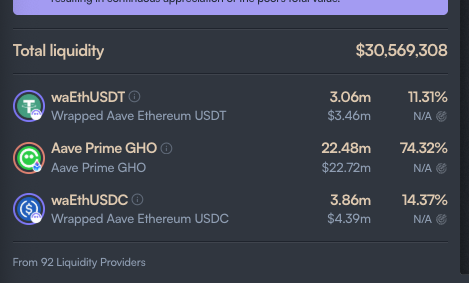

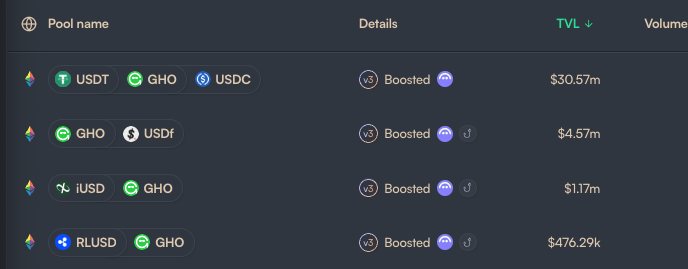

In [ ]:
# dex screener is not showing this as accurate it misses the othe rpools

# maybe aliaises, GHO -> stGHO, aGHO (manually)

In [ ]:
# it misses these pools 

# sanity check, this is showing on mainnet that there is only 8.7M total in the other pair, and we currently own, 4.4M GHO,

that seems way too high

check balancer and curve 

In [ ]:
large_pairs_df[large_pairs_df['base_token_symbol']  == 'GHO']['usd_quote_liqudity'].sum().round()

np.float64(8810014.0)

In [ ]:
large_pairs_df['usd_quote_liqudity_thousands'] = large_pairs_df['usd_quote_liqudity'] / 1000
large_pairs_df['usd_base_liqudity_thousands'] = large_pairs_df['usd_base_liqudity'] / 1000


In [ ]:
large_pairs_df[large_pairs_df['base_token_symbol']  == 'GHO']['usd_quote_liqudity_thousands'].sum() * 1000
# this is 

np.float64(8810013.762777003)

In [ ]:
large_pairs_df[large_pairs_df['base_token_symbol']  == 'GHO']

,pairAddress,dexId,base_token_address,base_token_name,base_token_symbol,quote_token_address,quote_token_name,quote_token_symbol,liquidity_usd,liquidity_base,liquidity_quote,usd_quote_liqudity,usd_base_liqudity,total_liquidity_usd,usd_quote_liqudity_thousands,usd_base_liqudity_thousands
161,0x5c95d4B1C3321CF898D25949F41D50Be2dB5bc1d,uniswap,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48,USD Coin,USDC,816532.65,6.572120e+05,1.601380e+05,1.601068e+05,6.560258e+05,8.161326e+05,160.106760,656.025846
162,0x4628f13651eaD6793F8d838B34B8f8522Fb0cc52,curve,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0x66a1E37c9b0eAddca17d3662D6c05F4DECf3e110,Resolv USD,USR,6859967.24,5.129077e+06,1.736551e+06,1.735431e+06,5.119820e+06,6.855251e+06,1735.430709,5119.819900
163,0x74345504Eaea3D9408fC69Ae7EB2d14095643c5b,curve,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0x085780639CC2cACd35E474e71f4d000e2405d8f6,f(x) USD,fxUSD,4377779.07,1.855197e+06,2.529798e+06,2.524978e+06,1.851849e+06,4.376826e+06,2524.977640,1851.848689
164,0x8a4f252812dFF2A8636E4F7EB249d8FC2E3bd77f-0x4...,curve,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,Wrapped Ether,WETH,2760977.08,1.370162e+06,3.836579e+02,1.391468e+06,1.367689e+06,2.759157e+06,1391.468385,1367.689094
165,0x8353157092ED8Be69a9DF8F95af097bbF33Cb2aF-0x4...,balancer,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0xdAC17F958D2ee523a2206206994597C13D831ec7,Tether USD,USDT,248399.57,1.539850e+05,9.472700e+04,9.475928e+04,1.537071e+05,2.484664e+05,94.759284,153.707084
166,0x670a72e6D22b0956C0D2573288F82DCc5d6E3a61,curve,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0x4c9EDD5852cd905f086C759E8383e09bff1E68B3,USDe,USDe,1813772.49,1.452886e+06,3.624760e+05,3.629185e+05,1.450264e+06,1.813182e+06,362.918543,1450.263791
167,0x635EF0056A597D13863B73825CcA297236578595,curve,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0xf939E0A03FB07F59A73314E73794Be0E57ac1b4E,Curve.Fi USD Stablecoin,crvUSD,2823995.24,2.305739e+06,5.221560e+05,5.221539e+05,2.301578e+06,2.823731e+06,522.153910,2301.577539
168,0x8353157092ED8Be69a9DF8F95af097bbF33Cb2aF-0x4...,balancer,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48,USD Coin,USDC,257733.50,1.498660e+05,1.080590e+05,1.080379e+05,1.495955e+05,2.576334e+05,108.037920,149.595518
169,0x8a4f252812dFF2A8636E4F7EB249d8FC2E3bd77f-0x4...,curve,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0xcbB7C0000aB88B473b1f5aFd9ef808440eed33Bf,Coinbase Wrapped BTC,cbBTC,2756177.52,1.368253e+06,1.168310e+01,1.387392e+06,1.365784e+06,2.753175e+06,1387.391943,1365.783539
170,0x2b3fec4acbfce6ae91d529f88a5d6d438de36a457907...,uniswap,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,GHO,0x0000000000000000000000000000000000000000,Ether,ETH,12916.60,7.466224e+03,1.494200e+00,NaN,7.452749e+03,NaN,NaN,7.452749


In [ ]:
prices[prices['token_address'] == '0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f']

# 

,token_address,usd_price,last_updated_at
62,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,0.998474,1753314203


In [ ]:
sub_df.columns

Index(['pairAddress', 'dexId', 'base_token_address', 'base_token_name',
       'base_token_symbol', 'quote_token_address', 'quote_token_name',
       'quote_token_symbol', 'liquidity_usd', 'liquidity_base',
       'liquidity_quote', 'usd_quote_liqudity', 'usd_base_liqudity',
       'total_liquidity_usd'],
      dtype='object')

In [ ]:
rows = [
    {"from_token": outer_k, "to_token": inner_k, "pair_liqudity": v}
    for outer_k, inner_dict in our_token_to_total_other_token_liquidity.items()
    for inner_k, v in inner_dict.items()
]

exit_liqudity_df = pd.DataFrame(rows)
exit_liqudity_df = exit_liqudity_df.groupby('from_token')['pair_liqudity'].sum().round().sort_values(ascending=False)
exit_liqudity_df

from_token
WETH       372858441.0
USDT       298574479.0
USDC       147661101.0
scrvUSD    123457919.0
sUSDe      110992065.0
sUSDS       57660399.0
DOLA        54993919.0
osETH       47222519.0
rETH        43859893.0
crvUSD      40858051.0
reUSD       35485784.0
stETH       28711131.0
weETH       21735814.0
pxETH       19553601.0
sDOLA       14367567.0
GHO          8811604.0
deUSD        7116893.0
alUSD        6250563.0
ezETH        1079263.0
ETHx          216579.0
Name: pair_liqudity, dtype: float64

In [ ]:
our_exposure = df.groupby('token_symbol')['quantity'].sum()


our_exposure_with_liquidity = exit_liqudity_df.to_frame().join(our_exposure, how='left')
import plotly.express as px
import plotly.io as pio

pio.templates.default = "plotly_white"

fig = px.bar(
    our_exposure_with_liquidity,
    x=our_exposure_with_liquidity.index,
    y=['pair_liqudity', 'quantity'],
    title='Exit Liquidity vs Our Exposure'
)

fig.update_layout(barmode='group')  # Ensures bars are side-by-side
fig.show()